# Ensemble methods

In [1]:
import lime
import pdpbox
import warnings
import graphviz
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

import xgboost as xgb
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve,
                             auc, precision_recall_curve, make_scorer, confusion_matrix, plot_roc_curve)

# Importing the cleaned data
df = pd.read_csv('stroke_clean.csv', index_col='id')
print('Dataset: ', df.shape)
df.head()

Dataset:  (4908, 18)


,gender,age,hypertension,heart_disease,ever_married,residence_type,avg_glucose_level,bmi,govt_job,never_worked,private,self-employed,children,never_smoked,formerly_smoked,smokes,unknown_smoker,stroke
id,,,,,,,,,,,,,,,,,,
9046,0,67.0,0,1,1,1,228.69,36.6,0,0,1,0,0,0,1,0,0,1
31112,0,80.0,0,1,1,0,105.92,32.5,0,0,1,0,0,1,0,0,0,1
60182,1,49.0,0,0,1,1,171.23,34.4,0,0,1,0,0,0,0,1,0,1
1665,1,79.0,1,0,1,0,174.12,24.0,0,0,0,1,0,1,0,0,0,1
56669,0,81.0,0,0,1,1,186.21,29.0,0,0,1,0,0,0,1,0,0,1


In [2]:
# Do a train-test split
x = np.array(df.loc[:, df.columns != 'stroke'])
y = np.array(df['stroke'])
test_size = 0.3

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = 41)

### Exploratory data analysis

After cleaning the data we do some quickly analysis of it to understand some of the underlying trends.

In [3]:
print("Number/percentage of stroke examples in dataset: ", df[df.stroke == 1].shape[0], df[df.stroke == 1].shape[0]/df.shape[0])
print("Number/percentage of non-stroke examples in dataset: ", df[df.stroke == 0].shape[0], df[df.stroke == 0].shape[0]/df.shape[0])
print()
print("Number/percentage of stroke examples in training set: ", x_train[y_train == 1].shape[0], x_train[y_train == 1].shape[0]/x_train.shape[0])
print("Number/percentage of non-stroke examples in training set: ", x_train[y_train == 0].shape[0], x_train[y_train == 0].shape[0]/x_train.shape[0])
print()
print("Number/percentage of stroke examples in test set: ", x_test[y_test == 1].shape[0], x_test[y_test == 1].shape[0]/x_test.shape[0])
print("Number/percentage of non-stroke examples in test set: ", x_test[y_test == 0].shape[0], x_test[y_test == 0].shape[0]/x_test.shape[0])

Number/percentage of stroke examples in dataset:  209 0.04258353708231459
Number/percentage of non-stroke examples in dataset:  4699 0.9574164629176855

Number/percentage of stroke examples in training set:  148 0.04308588064046579
Number/percentage of non-stroke examples in training set:  3287 0.9569141193595342

Number/percentage of stroke examples in test set:  61 0.041412084181941616
Number/percentage of non-stroke examples in test set:  1412 0.9585879158180584


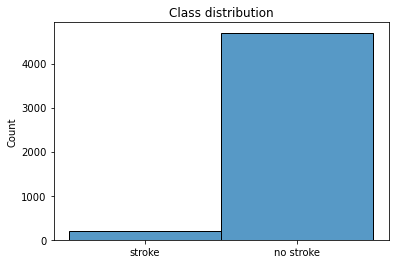

In [4]:
# Dataset is very skewed
d = np.where(df.stroke == 1, "stroke", "no stroke")
sns.histplot(data = d).set_title("Class distribution")
plt.show()

Text(0.5, 1.0, 'Gender/class distribution')

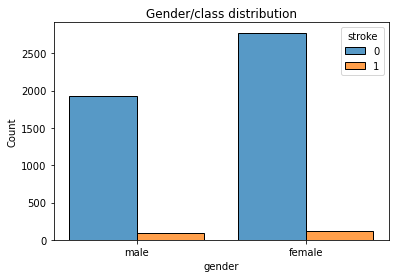

In [5]:
a = df
a.gender = np.where(df.gender == 1, "female", "male")
sns.histplot(data=a, x="gender", hue="stroke", multiple="dodge", shrink=.8).set_title("Gender/class distribution")

Text(0.5, 1.0, 'Age/class distribution')

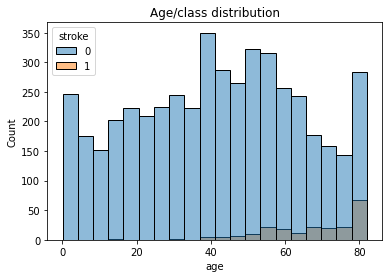

In [6]:
sns.histplot(data = df, x="age", hue="stroke").set_title("Age/class distribution")

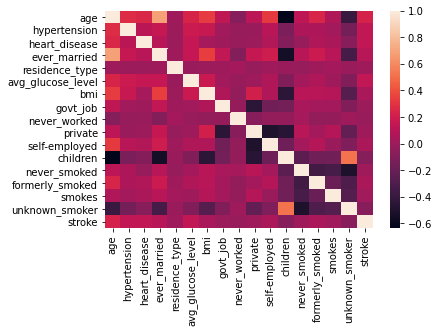

In [7]:
corrMatrix = df.corr()
sns.heatmap(corrMatrix)
plt.show()

In [8]:
# Necessary functions

def roc(model_fit, x_test, y_test):
    baseline_probs = [0 for _ in range(len(y_test))]
    probs = model_fit.predict_proba(x_test)[:, 1]

    # calculate scores
    baseline_auc = roc_auc_score(y_test, baseline_probs)
    pc_auc = roc_auc_score(y_test, probs)

    # calculate roc curves
    baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
    fpr, tpr, thresholds = roc_curve(y_test, probs, drop_intermediate = False)
    
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print("Best Threshold=%f, G-Mean=%.3f" % (thresholds[ix], gmeans[ix]))
    a = np.where(probs >= thresholds[ix], 1, 0)
    tn, fp, fn, tp = confusion_matrix(y_test, a).ravel()
    print("tn: ", tn)
    print("tp: ", tp)
    print("fn: ", fn)
    print("fp: ", fp)
    print("accuracy: ", accuracy_score(y_test, a))
    print("precision: ", precision_score(y_test, a))
    print("recall: ", recall_score(y_test, a))
    print("f1: ", f1_score(y_test, a))

    # plot the roc curve for the model
    plt.figure()
    plt.plot(baseline_fpr, baseline_tpr, linestyle = "--", color = "lightgrey")
    plt.plot(fpr, tpr, marker = ".", label = "ROC AUC=%.3f" % (pc_auc), color = "orange")
    plt.scatter(fpr[ix], tpr[ix], marker="o", color="black", label="Best")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
    
def precision_recall(model_fit, x_test, y_test):
    probs = model_fit.predict_proba(x_test)[:, 1]
    
    # predict class values
    precision, recall, _ = precision_recall_curve(y_test, probs)
    no_skill = len(y_test[y_test==1]) / len(y_test)
    
    yhat = model_fit.predict(x_test)
    model_f1, model_auc = f1_score(y_test, yhat), auc(recall, precision)
    
    # plot the precision-recall curves
    plt.figure()
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color = "lightgray")
    plt.plot(recall, precision, marker=".", label="f1=%.3f auc=%.3f" % (model_f1, model_auc), color = "orange")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

def train_error(model_fit):
    train_pred = model_fit.predict(x_train)

    print("Train errors:")
    print()
    print("accuracy: %.3f" % accuracy_score(y_train, train_pred))
    print("precision: %.3f" % precision_score(y_train, train_pred, zero_division = 0))
    print("recall: %.3f" % recall_score(y_train, train_pred, zero_division = 0))
    print("f1: %.3f" % f1_score(y_train, train_pred, zero_division = 0))
    print()
    
def test_error(model_fit):
    test_pred = model_fit.predict(x_test)

    print("Test errors:")
    print()
    print("accuracy: %.3f" % accuracy_score(y_test, test_pred))
    print("precision: %.3f" % precision_score(y_test, test_pred, zero_division = 0))
    print("recall: %.3f" % recall_score(y_test, test_pred, zero_division = 0))
    print("f1: %.3f" % f1_score(y_test, test_pred, zero_division = 0))

    cm_test = confusion_matrix(y_test, test_pred)
    group_names = ["TN", "FP", "FN", "TP"]
    group_counts = ["{0:0.0f}".format(value) for value in cm_test.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm_test, annot=labels, fmt = "", annot_kws={"size": 16}, linewidths = 0.5, cmap="YlGnBu")

### How to evaluate performance?

In this binary classification problem we are dealing with a very imbalanced dataset. The majority class has 96% of the observations, while the minority class only has 4%. This is typical in medical datasets that deals with prediction of rare occurrences like stroke. We will always have many more examples of people without the condition, than with, making it very dificult to correctly identify the general pattern behind the minority class. In addition, with skewed medical datasets like this one, false negative rates and false positive rates do not have equal weight. In our dataset, a false negative will be much more dangerous than a false positive, as it is better to predict that someone will get a stroke and get it wrong, than the other way around.

For binary classification problems it is typical to use accuracy as the metric to evaluate performance of the method. Accuracy is the ratio of the correctly predicted observations to the total number of observation. With an imbalanced problem like the one we have, accuracy will not be a good preformance measure. To show why, if we simply make a classification model which predicts all observations as class 0, "no stroke", we will get a very high accuracy which will not reflect the difference in size between the two classes.

\begin{align*}
    \text{accuracy} = \frac{\text{tp + tn}}{\text{tp + tn + fn + fp}} = \frac{4699 + 0}{4699 + 0 + 209 + 0} = 0.957
\end{align*}

Other measures which are better with dealing with unsymmetric classes are precision and recall. Precision is the ratio of correctly predicted positive observations to the total number of predicted positive observations. Precision favors a low false positive rate. Recall is the ratio of correctly predicted positive observations to all the observations in the actual class. This favors the false negative rate, which is important when we want to minimize the number of false negatives. Both of these metrics would becomes zero in the case above.

\begin{align*}
    \text{precision} = \frac{\text{tp}}{\text{tp + fp}}, \quad \text{recall} = \frac{\text{tp}}{\text{tp + fn}}
\end{align*}

To be able to take into account both recall and precision, we can use the f1-measure, which is the harmoic mean of precision and recall:

\begin{align*}
    \text{f1} = \frac{2\cdot \text{precision} \cdot \text{recall}}{\text{precision + recall}}
\end{align*}

Instead of using the predicted values from using the threshold 0.5, we could also calculate both ROC-AUC and precision-recall-AUC to find better thresholds. ROC-AUC is the area under the ROC curve which plots the true positive rate against the false positive rate. The precision-recall curve uses precision instead of false positive rate, and can be considered better in the case when we have an unproportional large amount of true negatives, since neither recall or precision takes this into account. We calculate the best threshold by the G-mean.

Sklearn also icludes several metric which tries to balance out the classes during evaluation. The balanced accuracy score is defined as the average of recall obtained on each class. Weighted F1 calculates precision and recall for each label and finds their average weighted by support. We choose to use the weighted F1.

### Hyperparameter tuning

To find the optimal hypoerparameters we will do a gridsearch over the gridspace spesified for each method, combined with a 5-fold cross-validation, such that the chosen hyperparameters does not make the model overfit the training data. We use the weighted F1 as the scorer to choose the optimal hyperparameters.

In [9]:
metric = 'recall' # Tried: roc_auc, f1_weighted (best so far), balanced acc (actually best so far)

### Decision tree

We start by implementing a simple deicision tree to test the GrisSearhCV and get a baseline error.

In [10]:
warnings.filterwarnings('ignore')

parameters = {'max_depth': range(1, 10, 1),          # The maximum depth of the tree
              'min_samples_split': range(2, 5, 1),  # The minimum number of samples required to split an internal node
              'min_samples_leaf': range(1, 10, 1)}   # The minimum number of samples required to be at a leaf node

clf = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 23,
                                                      criterion = 'gini'),
                   param_grid = parameters,
                   scoring = metric,
                   cv = 5)

clf = clf.fit(x_train, y_train)
results = clf.cv_results_
best_params = clf.best_params_

print("Best hyperparameter from the cv-gridsearch:")
print(best_params)

warnings.filterwarnings('always')

Best hyperparameter from the cv-gridsearch:
{'max_depth': 9, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [11]:
tree = DecisionTreeClassifier(**best_params)
tree_fit = tree.fit(x_train, y_train)

#display(graphviz.Source(export_graphviz(tree_fit, feature_names = df.columns[:-1], filled = True, class_names = ("no stroke", "stroke"))))

Train errors:

accuracy: 0.963
precision: 0.683
recall: 0.277
f1: 0.394

Test errors:

accuracy: 0.948
precision: 0.143
recall: 0.049
f1: 0.073


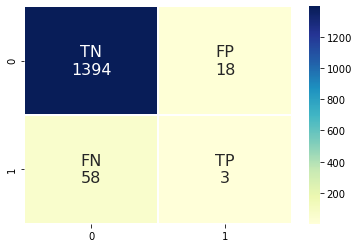

In [12]:
train_error(model_fit = tree_fit)
test_error(model_fit = tree_fit)

Best Threshold=0.009901, G-Mean=0.618
tn:  1135
tp:  29
fn:  32
fp:  277
accuracy:  0.790224032586558
precision:  0.09477124183006536
recall:  0.47540983606557374
f1:  0.15803814713896458


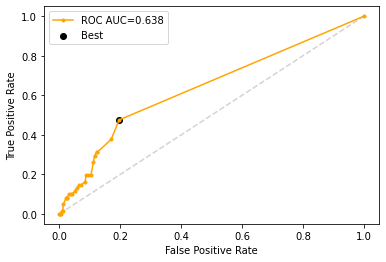

In [13]:
roc(model_fit = tree_fit, x_test = x_test, y_test = y_test)

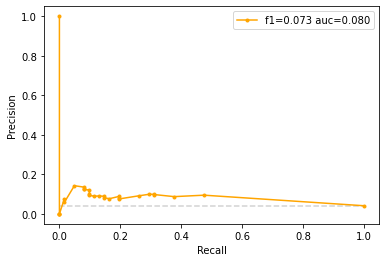

In [14]:
precision_recall(model_fit = tree_fit, x_test = x_test, y_test = y_test)

### Random Forest

Try to fit a random forest model to the stroke classification problem. Use cross-validation grid search to find the optimal parameters.

In [15]:
warnings.filterwarnings('ignore')

parameters = {'n_estimators': [1, 2, 3, 5, 10],
              'max_features': (2, 'sqrt', 8),
              'max_depth': range(1, 11, 1)}

clf = GridSearchCV(estimator = RandomForestClassifier(random_state = 23,
                                                      criterion = 'gini',
                                                      bootstrap = True,
                                                      oob_score = False),
                  param_grid = parameters,
                  scoring = metric, # 'f1_weighted', 'recall'
                  cv = 5)

clf = clf.fit(x_train, y_train)
results = clf.cv_results_
best_params = clf.best_params_
print("Best hyperparameter from the cv-gridsearch:")
print(best_params)

warnings.filterwarnings('always')

Best hyperparameter from the cv-gridsearch:
{'max_depth': 9, 'max_features': 8, 'n_estimators': 1}


Train errors:

accuracy: 0.963
precision: 0.598
recall: 0.432
f1: 0.502

Test errors:

accuracy: 0.927
precision: 0.117
recall: 0.115
f1: 0.116


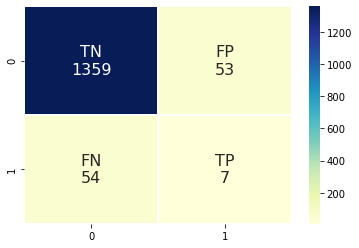

In [16]:
rf = RandomForestClassifier(**best_params)
rf_fit = rf.fit(x_train, y_train)

train_error(model_fit = rf_fit)
test_error(model_fit = rf_fit)

Best Threshold=0.009434, G-Mean=0.513
tn:  1192
tp:  19
fn:  42
fp:  220
accuracy:  0.8221317040054311
precision:  0.0794979079497908
recall:  0.3114754098360656
f1:  0.12666666666666668


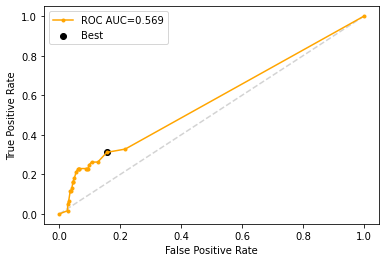

In [17]:
roc(model_fit = rf_fit, x_test = x_test, y_test = y_test)

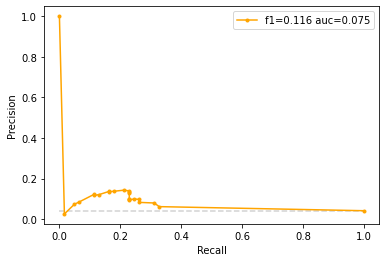

In [18]:
precision_recall(model_fit = rf_fit, x_test = x_test, y_test = y_test)

### Weighted Random Forest

Try a weighted random forest to even out the imbalanced classes. The weighted random forest works bu changing the weight the each class has when calculating the impurity score at each split. When the data has a skewed class distribution the impurity calculating becomes biased such that false negatives for the majority class is permitted.

From using random forest to learn imbalanced data: Another approach to make random forest more suitable for learning from extremely imbalanced data follows the idea of cost sensitive learning. Since the RF classifier tends to be biased towards the majority class, we shall place a heavier penalty on misclassifying the minority class.

In python this can easily be achieved by using argument "class_weight". The value "balanced" uses the inverse weighting from the training dataset, giving focus to the minority class. Using the value "balanced_subsample" instead, the class weighting changes based on the class distribution in each bootstrap sample, instead of the entire dataset. As we expect the bootstrap samples to contain even fewer classifications of stroke, we use the "balance_subsample value" when training the weighted random forest.

In [42]:
np.random.seed(41)
warnings.filterwarnings('ignore')

parameters = {'n_estimators': [5, 10, 30, 50, 100],
              'max_features': (2, 'sqrt', 8),
              'max_depth': range(1, 10, 1)}

clf = GridSearchCV(estimator = RandomForestClassifier(random_state = 23,
                                                      criterion = 'gini',
                                                      class_weight = 'balanced_subsample',
                                                      bootstrap = True,
                                                      oob_score = False),
                  param_grid = parameters,
                  scoring = metric,
                  cv = 5)

clf = clf.fit(x_train, y_train)
results = clf.cv_results_
best_params = clf.best_params_
print("Best hyperparameter from the cv-gridsearch:")
print(best_params)

warnings.filterwarnings('always')

Best hyperparameter from the cv-gridsearch:
{'max_depth': 1, 'max_features': 8, 'n_estimators': 30}


Train errors:

accuracy: 0.655
precision: 0.101
recall: 0.892
f1: 0.182

Test errors:

accuracy: 0.654
precision: 0.100
recall: 0.918
f1: 0.180


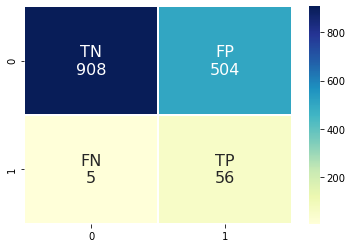

In [43]:
wrf = RandomForestClassifier(**best_params, class_weight = "balanced_subsample")
wrf_fit = wrf.fit(x_train, y_train)

train_error(model_fit = wrf_fit)
test_error(model_fit = wrf_fit)

Best Threshold=0.501211, G-Mean=0.768
tn:  908
tp:  56
fn:  5
fp:  504
accuracy:  0.6544467073998642
precision:  0.1
recall:  0.9180327868852459
f1:  0.18035426731078907


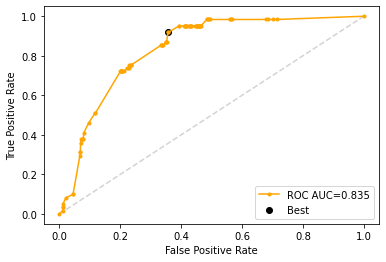

In [44]:
roc(model_fit = wrf_fit, x_test = x_test, y_test = y_test)

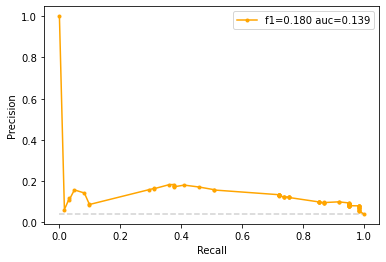

In [45]:
precision_recall(model_fit = wrf_fit, x_test = x_test, y_test = y_test)

### Balanced Random Forest

We get a small improvement in the wrf compared to the rf. An even bigger improvement can be made if we use the Balanced Random Forest. The method works by randomly undersampling from the majority class during the bootstrap sampling.  

The implementation of the BRF is from a python library called imbalanced-learn which offers a number of resampling techniques commenyl used in datasets showing strong between-class imbalance: https://pypi.org/project/imbalanced-learn/.

In [46]:
parameters = {'n_estimators': [5, 10, 30, 50],
              'max_features': (2, 'sqrt', 8),
              'max_depth': range(1, 10, 1)}

clf = GridSearchCV(estimator = BalancedRandomForestClassifier(random_state = 23,
                                                              criterion = 'gini',
                                                              class_weight = 'balanced_subsample',
                                                              bootstrap = True,
                                                              oob_score = False),
                  param_grid = parameters,
                  scoring = metric,
                  cv = 5)

clf = clf.fit(x_train, y_train)
results = clf.cv_results_
best_params = clf.best_params_
print(best_params)

{'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 30}


Train errors:

accuracy: 0.685
precision: 0.107
recall: 0.858
f1: 0.190

Test errors:

accuracy: 0.686
precision: 0.103
recall: 0.852
f1: 0.183


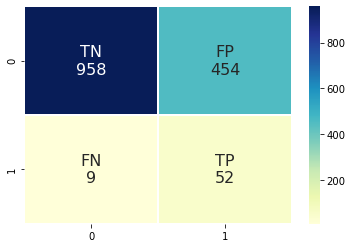

In [47]:
brf = BalancedRandomForestClassifier(**best_params, class_weight = 'balanced_subsample')
brf_fit = brf.fit(x_train, y_train)

train_error(model_fit = brf_fit)
test_error(model_fit = brf_fit)

Best Threshold=0.502586, G-Mean=0.766
tn:  971
tp:  52
fn:  9
fp:  441
accuracy:  0.6945010183299389
precision:  0.10547667342799188
recall:  0.8524590163934426
f1:  0.18772563176895307


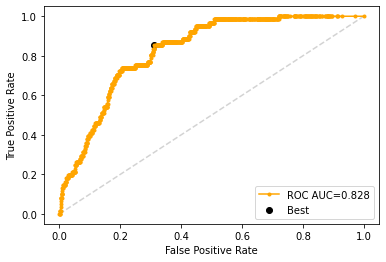

In [48]:
roc(model_fit = brf_fit, x_test = x_test, y_test = y_test)

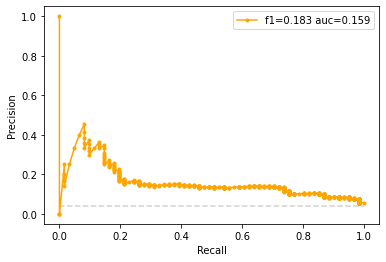

In [49]:
precision_recall(model_fit = brf_fit, x_test = x_test, y_test = y_test)

### Gradient boosting

Train errors:

accuracy: 0.967
precision: 1.000
recall: 0.223
f1: 0.365

Test errors:

accuracy: 0.955
precision: 0.000
recall: 0.000
f1: 0.000


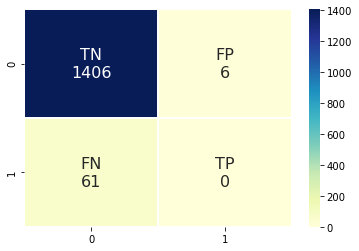

In [27]:
gb = GradientBoostingClassifier(random_state = 41)
gb_fit = gb.fit(x_train, y_train)

train_error(model_fit = gb_fit)
test_error(model_fit = gb_fit)

### XgBoost

Try to implement XGBoost to make performance better.

In [1]:
parameters = {'n_estimators': [10]}
              #'eta': [0, 0.2, 0.4, 0.6, 0.8, 1],
              #'gamma': range(0, 10, 2),
              #'reg_lambda': range(1, 5, 1),
              #'reg_alpha': range(0, 5, 1),
              #'max_depth': range(1, 10, 1)}

clf = GridSearchCV(estimator = xgb.XGBClassifier(random_state = 23, booster = 'gbtree'),
                   param_grid = parameters,
                   scoring = metric,
                   cv = 5)

clf = clf.fit(x_train, y_train)
results = clf.cv_results_
best_params = clf.best_params_
print(best_params)

NameError: name 'GridSearchCV' is not defined

In [ ]:
#xgb_model = xgb.XGBClassifier(n_estimators = 100,
#                       reg_lambda = 1,
#                       gamma = 0,
#                       max_depth = 3)
xgb_model = xgb.XGBClassifier(**best_params)
xgb_fit = xgb_model.fit(x_train, y_train)

train_error(model_fit = xgb_fit)
test_error(model_fit = xgb_fit)

In [ ]:
# Importance of each feature
pd.DataFrame(xgb_model.feature_importances_.reshape(1, -1), columns=df.columns[:-1])

### Interpreting the results: XAI

Which packages do we need to do this? pdpbox, alepython, lime...

Global methods:
* Linear model (standardized coeffs, shapley regression)
* XGBoost/RF (gini importance)
* Partial dependence plots
* ALE plots

Local methods:
* LIME
* Shapley
* Counterfactual explanations

Links:
* https://machinelearningmastery.com/feature‐importance‐and‐feature‐selection‐with‐xgboost‐in‐python/

#### Global methods

Use the gini importance and look at some partial dependence plots for the most important features.

#### Local methods

Use lime, counterfactual and shapley values to explain some datapoints.